# Практическая работа №4

## Вгружаем модель

In [7]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели из предыдущих практик
model = tf.keras.models.load_model('/content/mnist_model.h5')
# Проверка точности модели до атаки
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9715 - loss: 0.0998
Test accuracy on clean images: 0.9754999876022339


## Произведение атаки

In [2]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.3 MB/s eta 0:00:00


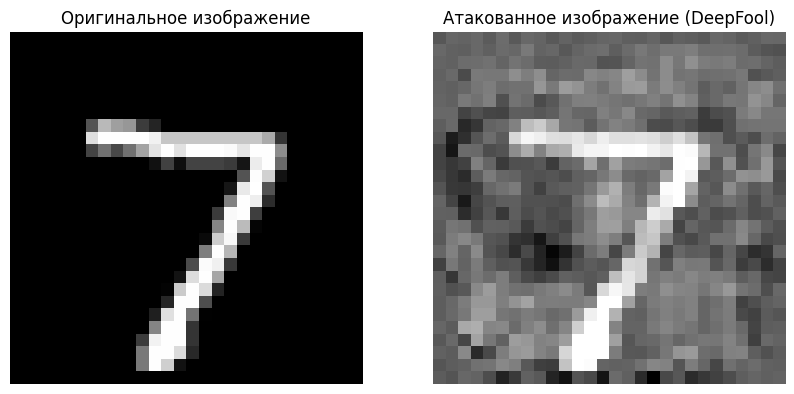

In [10]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

attack = fb.attacks.L2DeepFoolAttack(steps=5)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Атакованное изображение (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

## Оценка модели на противоречивых примерах

In [13]:
adversarial_images = []

for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples: {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 128.9736
Accuracy on adversarial examples: 0.0


## Выводы
Точность модели на атакованных примерах снизилась крайне сильно и составляет в районе 0%, следовательно, можно сделать вывод, что модель очень подвержена данному типу атаки. Также стоит отметить, что атака на скомпилированной модели на тестовом изображении создала сильные видимые помехи, что могло повлиять на результаты.
